# Chapter12. 使用神经网络识别图像
- 从概念层次理解多层神经网络
- 训练用于图像分类的神经网络
- 实现强大的反向传播算法
- 测试已实现的神经网络

In [1]:
from IPython.display import Image
%matplotlib inline

## 1. 使用人工神经网络对复杂函数建模
### a. 单层神经网络回顾

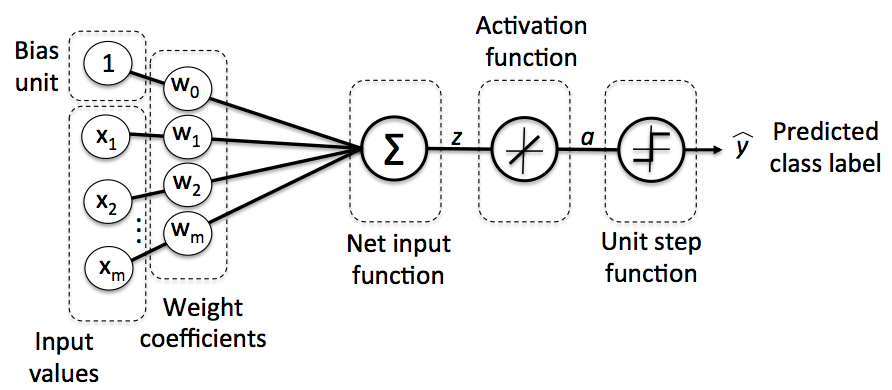

In [2]:
Image(filename='./images/12_01.png', width=600)

### b. 多层神经网络架构简介
使用多个单独的神经元连接为一个多层前馈神经网络（multi-layer feedforward neural network），也被称为多层感知器（multi-layer perceptron, MLP）。

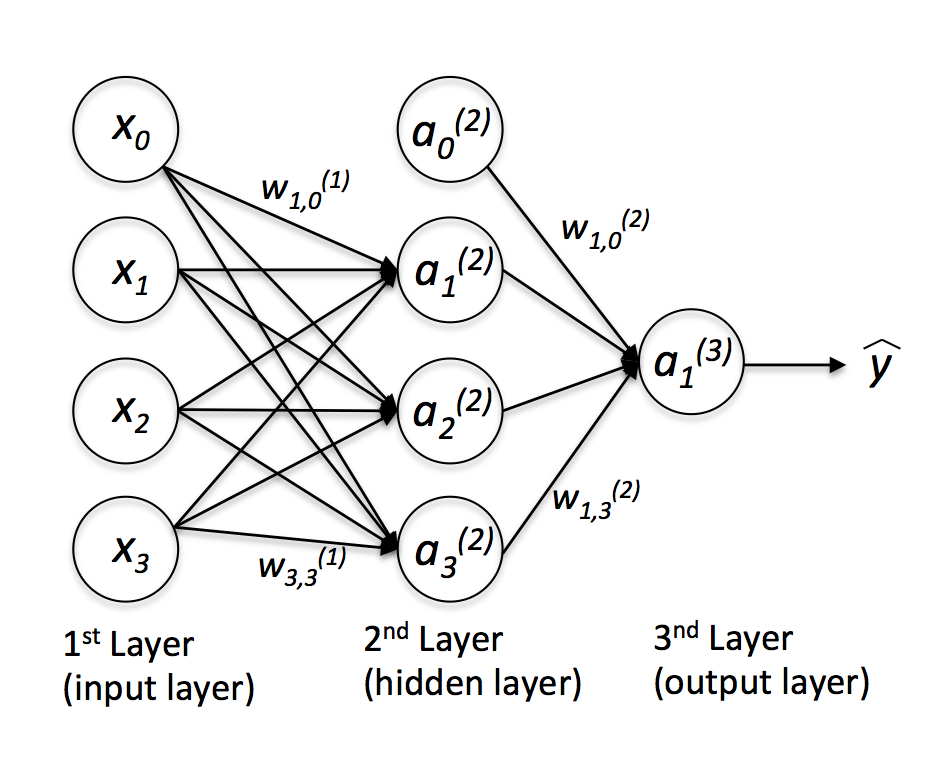

In [3]:
Image(filename='./images/12_02.png', width=400)

### c. 通过正向传播构造神经网络
1. 从输入层开始：通过网络向前传播训练数据集中的模式，以生成输出；
2. 基于网络的输出，通过计算一个代价函数计算所需的最小化误差；
3. 反向传播误差，计算其对网络中每个权重的偏导数，并更新模型

$${\bf z}^{(2)} = {\mit W}^{(1)}{\mit a}^{(1)}$$
$${\mit a}^{(1)} = \phi({\bf z}^{(2)})$$

其中，${\mit a}^{(1)}$ 是 $[m+1]\times1$ 维的样本及其偏置单元，${\mit W}^{(1)}$ 为 $h\times [m+1]$ 维的权重矩阵，其中 $h$ 为隐层神经元的数量。推广到全部的 $n$ 个样本上：

$$ {\mit Z}^{(1)} = {\mit W}^{(1)}[{\mit A}^{(1)}]^T$$

其中，${\mit A}^{(1)}$ 是一个 $n\times [m+1]$ 维的矩阵，上式相乘得到的是一个 $h\times n$ 维的净输入矩阵，再使用激励函数 $\phi(\cdot)$ 作用于净输入矩阵就可以得到下一层，在本例中也就是输出层的激励矩阵 ${\mit A}^{(2)}$：

$${\mit A}^{(2)}=\phi({\mit Z}^{(2)})$$

然后得到输出层的激励：

$${\mit Z}^{(3)} = {\mit W}^{(2)}{\mit A}^{(2)}$$

最后，将激励函数作用于激励，就可以得到每个类别对应的概率，然后使用one-hot编码的方式就得到了类别输出：

$${\mit A}^{(3)}=\phi({\mit Z}^{(3)})$$

## 2. 手写数字的识别

### a. 获得MNIST（Mixed National Institue of Standards and Technology）数据集
- 训练数据集图像：train-images-idx3-ubyte.gz
- 训练集类标：train-labels-idx1-ubyte.gz
- 测试集图像：t10k-images-idx3-ubyte.gz
- 测试集类标：t10k-labels-idx1-ubyte.gz

解压数据集并将其读入Numpy数组用来训练多层感知器模型，关于详细的代码解释参见p219：

In [5]:
import os 
import struct
import numpy as np

def load_mnist(path, kind='train'):
    """从指定路径加载MNIST数据集"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        # 首先读取幻数，和条目数量，这些信息记录在文件的前8个字节中
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        # 图片的前16个字节保存了幻数、样本数量、行数、列数等信息
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        
    return images, labels

In [6]:
X_train, y_train = load_mnist('../datasets/MNIST/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [7]:
X_test, y_test = load_mnist('../datasets/MNIST/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


对数据进行还原，把784的行向量转化成28x28图像，进行显示。

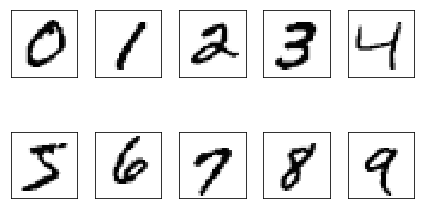

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()

# 重新转化为28x28的图像
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

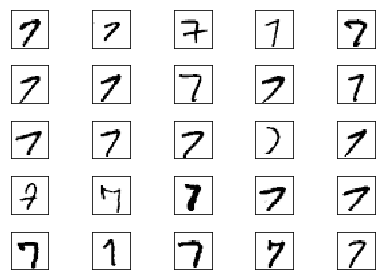

In [11]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()

for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### b. 实现一个多层感知器
在这里我们将实现一个包含一个输入层、一个隐层和一个输出层的多层感知器。

In [18]:
import numpy as np
from scipy.special import expit
import sys

class NeuralNetMLP(object):
    """
    前馈神经网络/多层感知器
    
    Parameters
    ------------
    n_output : int
        输出层单元数量，和待分类的类别数量相同
    n_features : int
        特征数量，在这里就是图像的分辨率
    n_hidden : int (default: 30)
        隐层单元数量
    l1 : float (default: 0.0)
        L1-正则化参数
        无正则化为0.0
    l2 : float (default: 0.0)
        L2-正则化参数
        无正则化为0.0
    epochs : int (default: 500)
        迭代次数
    eta : float (default: 0.001)
        学习速率
    alpha : float (default: 0.0)
        动量学习进度的参数，它在上一轮迭代的基础上增加一个因子，
        用于加快权重的学习速度。
        w(t) := w(t) - (grad(t) + alpha * grad(t-1))
    decrease_const : float (default: 0.0)
        用于降低自适应速率eta的常数，随着迭代次数增加
        而随之递减以更好地确保收敛
    shuffle : bool (default: True)
        在每次迭代前打乱训练集顺序，防止算法陷入死循环
    minibatches : int (default: 1)
        每次迭代时，将训练数据划分为k个小批次，为了加速梯度
        下降的过程
    random_state : int (default: None)
        设置随机化状态以随机和初始化权重
        
    Attributes
    -----------
    cost_ : list
        每次迭代的平方损失和
    
    """
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):
        
        np.random.seed(random_state)
        self.n_output = n_output
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        # w1连接输入层和隐层的权重矩阵
        # w2连接隐层和输出层的权重矩阵
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    def _encode_labels(self, y, k):
        """
        对类别标签进行独热编码
        
        Parameters
        ------------
        y : array, shape = [n_samples]
            目标标签
        k : int
            类别数量
            
        Returns
        ------------
        onehot : array, shape = (n_labels, n_samples)
        
        """
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            # 例如y=9，那么除了第9个元素为1，其他都为0
            onehot[val, idx] = 1.0
        return onehot
    
    def _initialize_weights(self):
        """
        使用小随机数随机初始化权重
        
        """
        w1 = np.random.uniform(-1.0, 1.0, size=self.n_hidden * (self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        
        w2 = np.random.uniform(-1.0, 1.0, size=self.n_output * (self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        
        return w1, w2
    
    def _sigmoid(self, z):
        # 使用scipy.special.expit来避免在使用较小的z时发生溢出
        return expit(z)
    
    def _sigmoid_gradient(self, z):
        """
        计算sigmoid函数的导数
        
        """
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)
    
    def _add_bias_unit(self, X, how='column'):
        """
        对每层添加偏置单元（第一列或者第一行的第一个位置）
        
        """
        if how == 'column':
            # 新生成一个多了一列的矩阵
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        
        else:
            raise AttributeError("`how` must be `column` or `row`")
        
        return X_new
    
    def _feedforward(self, X, w1, w2):
        """
        计算前馈神经网络
        
        Parameters
        ------------
        X : array, shape = [n_samples, n_features]
            输入层的原始输入
        w1 : array, shape = [n_hidden_units, n_features]
            输入层 -> 隐藏层的权重矩阵
        w2 : array, shape = [n_output_units, n_hidden_units]
            隐藏层 -> 输出层的权重矩阵
            
        Returns
        ------------
        a1 : array, shape = [n_samples, n_features + 1]
            输入值X加上偏置单元
        z2 : array, shape = [n_hidden, n_samples]
            隐藏层的输入，也就是输入层的输出
        a2 : array, shape = [n_hidden + 1, n_samples]
            隐藏层的激励
        z3 : array, shape = [n_outputs_units, n_samples]
            输出层的输入
        a3 : array, shape = [n_outputs_units, n_samples]
            输出层的输出，也就是最终的类别
            
        """
        # 注释中假设隐层为30个单元，样本量为60000
        a1 = self._add_bias_unit(X, how='column')   # 60000 x 785
        z2 = w1.dot(a1.T)                           # 30 x 60000
        a2 = self._sigmoid(z2)                      # 30 x 60000
        a2 = self._add_bias_unit(a2, how='row')     # 31 x 60000
        z3 = w2.dot(a2)                             # 10 x 60000
        a3 = self._sigmoid(z3)                      # 10 x 60000
        
        return a1, z2, a2, z3, a3
    
    def _L2_reg(self, lambda_, w1, w2):
        """
        计算L2正则损失项
        
        """
        # 计算正则化不包含偏置单元
        return (lambda_ / 2.0) * (np.sum(w1[:, 1:] ** 2) + 
                                  np.sum(w2[:, 1:] ** 2))
    
    def _L1_reg(self, lambda_, w1, w2):
        """
        计算L1正则损失项
        
        """
        # 计算正则化不包含偏置单元
        return (lambda_ / 2.0) * (np.abs(w1[:, 1:]).sum() + 
                                  np.abs(w2[:, 1:]).sum())
    
    def _get_cost(self, y_enc, output, w1, w2):
        """
        计算损失函数
        
        Parameters
        ------------
        y_enc : array, shape = (n_labels, n_samples)
            独热编码后类别矩阵
        output : array, shape = [n_output_units, n_samples]
            前馈神经网络输出层的激励
        w1 : array, shape = [n_hidden_units, n_features]
            输入层 -> 隐藏层的权重矩阵
        w2 : array, shape = [n_output_units, n_hidden_units]
            隐藏层 -> 输出层的权重矩阵
            
        Returns
        ------------
        cost : float
            正则化损失
            
        """
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost
    
    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        """
        计算反向传播的梯度
        
        Parameters
        ------------
        a1 : array, shape = [n_samples, n_features + 1]
            输入值X加上偏置单元
        a2 : array, shape = [n_hidden + 1, n_samples]
            隐藏层的激励
        a3 : array, shape = [n_outputs_units, n_samples]
            输出层的输出，也就是最终的类别
        z2 : array, shape = [n_hidden, n_samples]
            隐藏层的输入，也就是输入层的输出
        y_enc : array, shape = (n_labels, n_samples)
            独热编码后类别矩阵
        w1 : array, shape = [n_hidden_units, n_features]
            输入层 -> 隐藏层的权重矩阵
        w2 : array, shape = [n_output_units, n_hidden_units]
            隐藏层 -> 输出层的权重矩阵
        
        Returns
        -----------
        grad1 : array, shape = [n_hidden_units, n_features]
            w1的梯度矩阵
        grad2 : array, shape = [n_output_units, n_hidden_units]
            w2的梯度矩阵
            
        """
        # 误差反向传播
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)
        
        # 正则化
        grad1[:, 1:] += self.l2 * w1[:, 1:]
        grad1[:, 1:] += self.l1 * np.sign(w1[:, 1:])
        grad2[:, 1:] += self.l2 * w2[:, 1:]
        grad2[:, 1:] += self.l1 * np.sign(w2[:, 1:])

        return grad1, grad2
    
    def predict(self, X):
        """
        预测类别标签
        
        Parameters
        ------------
        X : array, shape = [n_samples, n_features]
            输入层的原始输入
        
        Returns
        ------------
        y_pred : array, shape = [n_samples]
            预测的类别
            
        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')
        
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred
    
    def fit(self, X, y, print_progress=False):
        """
        使用训练数据集训练权重参数
        
        Parameters
        ------------
        X : array, shape = [n_samples, n_features]
            输入层的原始输入
        y : array, shape = [n_samples]
            目标标签
        print_progress : bool (default: False)
            打印进度
            
        Returns
        ------------
        self
        
        """
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)
        
        # 更新之前的权重矩阵
        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        
        for i in range(self.epochs):
            
            # 自适应学习速率
            self.eta /= (1 + self.decrease_const * i)
            
            if print_progress:
                sys.stderr.write('\rEpochs: %d/%d' % (i + 1, self.epochs))
                sys.stderr.flush()
                
            if self.shuffle:
                # 将样本随机打乱
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]
            
            # 设置minibatches的样本数量
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:
                
                # 前向传播
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3, 
                                      w1=self.w1, w2=self.w2)
                self.cost_.append(cost)
                
                # 通过反向传播计算梯度
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)
                
                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                # 更新权重矩阵
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
        
        return self

In [19]:
nn = NeuralNetMLP(n_output=10,
                  n_features=X_train.shape[1],
                  n_hidden=50,
                  l2=0.1,
                  l1=0.0,
                  epochs=1000,
                  eta=0.001,
                  alpha=0.001,
                  decrease_const=0.00001,
                  minibatches=50,
                  shuffle=True,
                  random_state=1)

In [20]:
nn.fit(X_train, y_train, print_progress=True)

Epochs: 1000/1000

绘制前50个批次的每50次迭代的损失函数值

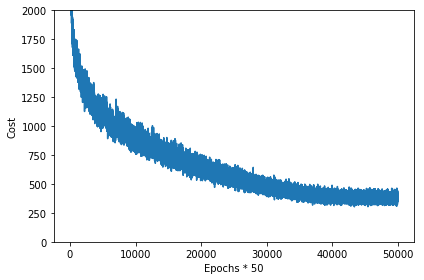

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs * 50')
plt.tight_layout()
# plt.savefig('./figures/cost.png', dpi=300)
plt.show()

从图中可见，由于使用了minibatch，图像中包含了明显的噪声。优化算法大约经过800(40000/50 = 800）次迭代后收敛，使用所有子批次的平均值，我们可以绘制一个相对平滑的图像：

In [23]:
batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

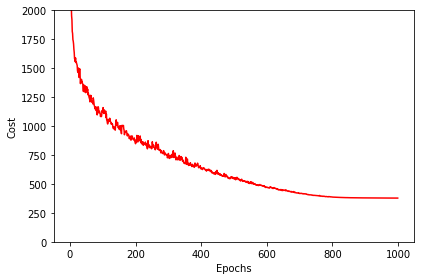

In [24]:
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

现在来输出精度值：

In [26]:
y_train_pred = nn.predict(X_train)
acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print("Training accuracy: %.2f%%" % (acc * 100))

Training accuracy: 97.54%


In [27]:
y_test_pred = nn.predict(X_test)
acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print("Test accuracy: %.2f%%" % (acc * 100))

Test accuracy: 95.72%


从准确率可以判断，模型有轻微的过拟合。

现在我们继续看一下多层感知器难以处理的一些图像：

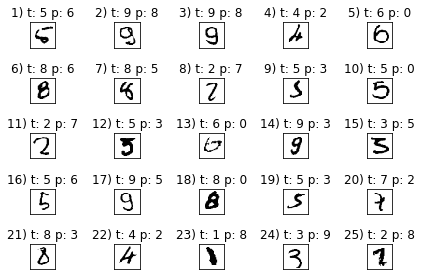

In [28]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i + 1, correct_lab[i], miscl_lab[i]))
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

从图中可以看出，某些图像很难分类。

## 3. 人工神经网络的训练
- 逻辑回归代价
- 反向传播算法

### a. 计算逻辑回归代价函数